# Tauroi Prediction Engine — Comprehensive EDA

**Dataset**: Chartmetric daily artist metrics (since 2019) joined with historical Kalshi WTA market prices (since June 2025).

**Goal**: Explore correlations between platform metrics and market prices, characterise the data the model operates on, and identify any observable relationships.

## Sections
1. Data Loading & Assembly
2. Chartmetric Feature Overview
3. Kalshi Price Fetch & Join
4. Univariate Distributions
5. Time Series Trends
6. Cross-Platform Correlations
7. Feature vs Kalshi Price Correlations
8. Volatility & Momentum Analysis
9. Lead-Lag: Do Features Move Before Prices?

In [79]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [80]:
import sys, pathlib, json, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats as sp_stats

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (14, 5)
plt.rcParams["figure.dpi"] = 120

PROJECT_ROOT = pathlib.Path.cwd().parent if pathlib.Path.cwd().name == "notebooks" else pathlib.Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

CACHE_DIR = PROJECT_ROOT / "cache"
print(f"Project root: {PROJECT_ROOT}")
print(f"Cache dir:    {CACHE_DIR}")

Project root: /Users/jeremy/Desktop/MS&E 108 Project/tauroi-prediction-engine
Cache dir:    /Users/jeremy/Desktop/MS&E 108 Project/tauroi-prediction-engine/cache


## 1. Data Loading — Chartmetric Cache

Load all per-artist Parquet files from the local cache and combine into a single panel DataFrame.

In [81]:
# Load manifest and all cache parquets
manifest = json.loads((CACHE_DIR / "_scan_manifest.json").read_text())

frames = []
for cm_id_str, entry in manifest.items():
    name = entry["name"]
    path = CACHE_DIR / f"scan_{cm_id_str}.parquet"
    if not path.exists():
        continue
    df = pd.read_parquet(path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").drop_duplicates(subset=["Date"], keep="last")
    df["artist_name"] = name
    df["artist_id"] = int(cm_id_str)
    frames.append(df)

cm = pd.concat(frames, ignore_index=True)
cm = cm.sort_values(["artist_name", "Date"]).reset_index(drop=True)

# Core feature columns present in the data
feature_cols = [c for c in cm.columns if c not in ("Date", "artist_name", "artist_id")]
print(f"Combined shape: {cm.shape}")
print(f"Artists: {cm['artist_name'].nunique()} — {sorted(cm['artist_name'].unique())}")
print(f"Date range: {cm['Date'].min().date()} → {cm['Date'].max().date()}")
print(f"\nFeature columns ({len(feature_cols)}):")
for c in feature_cols:
    non_null = cm[c].notna().sum()
    print(f"  {c:<40s}  {non_null:>6,d} non-null  ({non_null/len(cm):.0%})")
cm.head(3)

Combined shape: (12957, 14)
Artists: 5 — ['Bad Bunny', 'Billie Eilish', 'Bruno Mars', 'Taylor Swift', 'The Weeknd']
Date range: 2019-01-01 → 2026-02-17

Feature columns (11):
  spotify_monthly_listeners                 12,957 non-null  (100%)
  spotify_followers                         11,850 non-null  (91%)
  spotify_popularity                        12,228 non-null  (94%)
  tiktok_sound_posts_cumulative              9,081 non-null  (70%)
  youtube_channel_views                     12,658 non-null  (98%)
  instagram_followers                        9,610 non-null  (74%)
  deezer_fans                               10,829 non-null  (84%)
  shazam_count                                   0 non-null  (0%)
  tiktok_sound_posts_change                 12,957 non-null  (100%)
  soundcloud_followers                       6,893 non-null  (53%)
  wikipedia_views                           10,353 non-null  (80%)


,Date,spotify_monthly_listeners,spotify_followers,spotify_popularity,tiktok_sound_posts_cumulative,youtube_channel_views,instagram_followers,deezer_fans,shazam_count,tiktok_sound_posts_change,soundcloud_followers,wikipedia_views,artist_name,artist_id
0,2019-01-01,38563424.0,10167280.0,96.0,NaN,3.419552e+09,NaN,331042.0,NaN,0.0,NaN,NaN,Bad Bunny,214945
1,2019-01-02,39410280.0,10183119.0,96.0,NaN,3.419552e+09,NaN,NaN,NaN,0.0,NaN,NaN,Bad Bunny,214945
2,2019-01-03,39853964.0,10206512.0,96.0,NaN,3.440022e+09,NaN,334824.0,NaN,0.0,NaN,NaN,Bad Bunny,214945


## 2. Fetch Historical Kalshi Trade Prices

Pull daily OHLC+VWAP from Kalshi for every artist × month combination with a known ticker. This is the market price our model is compared against.

In [82]:
import importlib
import src.kalshi_client
import src.config
importlib.reload(src.kalshi_client)
importlib.reload(src.config)
from src.kalshi_client import KalshiClient
from src.config import load_settings
import re

settings = load_settings(require_secrets=True)
kalshi_api = KalshiClient(settings=settings)

# ── Dynamic ticker discovery from Kalshi API ─────────────────────
# Fetch ALL KXTOPMONTHLY events (open + settled) and extract
# artist→ticker mappings automatically, no hardcoding needed.

MONTH_CODES = {
    "JAN": "01", "FEB": "02", "MAR": "03", "APR": "04",
    "MAY": "05", "JUN": "06", "JUL": "07", "AUG": "08",
    "SEP": "09", "OCT": "10", "NOV": "11", "DEC": "12",
}

def discover_kxtopmonthly_tickers(client):
    """Query the Kalshi API for all KXTOPMONTHLY events and build
    a {year_month: {artist_name: ticker}} mapping plus winners."""
    tickers = {}   # "2025-06" → {"Bruno Mars": "KXTOPMONTHLY-25JUN-BMAR", ...}
    winners = {}   # "2025-06" → "Bruno Mars" | None

    for status in ("open", "settled"):
        # Use series_ticker filter to fetch only KXTOPMONTHLY events
        all_events = client.get_all_events(status=status, series_ticker="KXTOPMONTHLY")
        print(f"  [{status}] Fetched {len(all_events)} KXTOPMONTHLY events")

        for ev in all_events:
            etk = ev.get("event_ticker", "")
            if not etk.upper().startswith("KXTOPMONTHLY"):
                continue
            try:
                full = client.get_event(etk)
            except Exception:
                continue
            markets = full.get("markets", [])
            for m in markets:
                tk = m.get("ticker", "")
                artist = (m.get("yes_sub_title", "")
                          or m.get("custom_strike", {}).get("Artist", ""))
                if not artist:
                    continue
                # Parse month from ticker: KXTOPMONTHLY-25JUN-...
                parts = tk.split("-")
                if len(parts) < 3:
                    continue
                code = parts[1]  # e.g. "25JUN"
                yr = "20" + code[:2]
                mc = code[2:]
                if mc not in MONTH_CODES:
                    continue
                ym = f"{yr}-{MONTH_CODES[mc]}"
                tickers.setdefault(ym, {})[artist] = tk

                # Determine winner from settlement price
                result = m.get("result", "")
                if result == "yes":
                    winners[ym] = artist

    # Mark unresolved months
    for ym in tickers:
        if ym not in winners:
            winners[ym] = None

    return tickers, winners

print("Discovering KXTOPMONTHLY tickers from Kalshi API...")
KALSHI_TICKERS, ACTUAL_WINNERS = discover_kxtopmonthly_tickers(kalshi_api)

for ym in sorted(KALSHI_TICKERS):
    arts = list(KALSHI_TICKERS[ym].keys())
    winner = ACTUAL_WINNERS.get(ym, "?")
    tag = f"  ✓ {winner}" if winner else "  (unresolved)"
    print(f"  {ym}: {len(arts)} contracts — {', '.join(arts)}{tag}")
print(f"\nTotal: {sum(len(v) for v in KALSHI_TICKERS.values())} tickers across {len(KALSHI_TICKERS)} months")

Discovering KXTOPMONTHLY tickers from Kalshi API...


TypeError: get_all_events() got an unexpected keyword argument 'series_ticker'

In [ ]:
def fetch_all_trades(client, ticker, max_pages=20):
    all_trades = []
    cursor = None
    for _ in range(max_pages):
        trades, cursor = client.get_market_trades(ticker, limit=1000, cursor=cursor)
        all_trades.extend(trades)
        if not cursor or not trades:
            break
        time.sleep(0.05)
    return all_trades

def trades_to_daily(trades):
    if not trades:
        return pd.DataFrame()
    rows = []
    for t in trades:
        dt = pd.Timestamp(t.get("created_time", "")).tz_localize(None).normalize()
        price = t.get("yes_price", t.get("price", 0))
        vol = t.get("count", t.get("volume", 1))
        rows.append({"Date": dt, "price": price / 100.0, "volume": vol})
    df = pd.DataFrame(rows)
    daily = df.groupby("Date").agg(
        kalshi_open=("price", "first"),
        kalshi_high=("price", "max"),
        kalshi_low=("price", "min"),
        kalshi_close=("price", "last"),
        kalshi_vwap=("price", lambda x: np.average(x, weights=df.loc[x.index, "volume"])),
        kalshi_volume=("volume", "sum"),
    ).sort_index()
    return daily

# Fetch all Kalshi trade data using dynamically discovered tickers
kalshi_frames = []
for ym in sorted(KALSHI_TICKERS):
    for artist_name, ticker in KALSHI_TICKERS[ym].items():
        print(f"  Fetching {ym} / {artist_name} ({ticker})...", end=" ")
        trades = fetch_all_trades(kalshi_api, ticker)
        if trades:
            daily = trades_to_daily(trades)
            daily = daily.reset_index()
            daily["artist_name"] = artist_name
            daily["market_month"] = ym
            daily["ticker"] = ticker
            daily["actual_winner"] = ACTUAL_WINNERS.get(ym)
            kalshi_frames.append(daily)
            print(f"{len(daily)} days, {len(trades)} trades")
        else:
            print("no trades")
        time.sleep(0.1)

if kalshi_frames:
    kalshi = pd.concat(kalshi_frames, ignore_index=True)
    print(f"\nKalshi data: {len(kalshi):,} rows, {kalshi['artist_name'].nunique()} artists, {kalshi['market_month'].nunique()} months")
else:
    kalshi = pd.DataFrame()
    print("No Kalshi data fetched.")

No Kalshi data fetched.


## 3. Join: Chartmetric Features × Kalshi Prices

Inner-join on `(artist_name, Date)` to create the full analysis dataset. Each row has daily Chartmetric metrics **and** Kalshi market price for the same artist on the same day.

In [ ]:
# Join Chartmetric features with Kalshi prices
if not kalshi.empty:
    joined = pd.merge(cm, kalshi, on=["artist_name", "Date"], how="inner")
    print(f"Joined dataset: {joined.shape[0]:,} rows × {joined.shape[1]} columns")
    print(f"Date range: {joined['Date'].min().date()} → {joined['Date'].max().date()}")
    print(f"Artists:    {sorted(joined['artist_name'].unique())}")
    print(f"Months:     {sorted(joined['market_month'].unique())}")
    print()
    display(joined.describe().round(2))
else:
    joined = pd.DataFrame()
    print("No joined data — Kalshi fetch returned empty.")

No joined data — Kalshi fetch returned empty.


In [ ]:
# Save the full joined dataset for team use
output_dir = PROJECT_ROOT / "data" / "eda"
output_dir.mkdir(parents=True, exist_ok=True)
today = pd.Timestamp.now().strftime("%Y-%m-%d")

if not joined.empty:
    out_csv = output_dir / f"full_joined_dataset_{today}.csv"
    joined.to_csv(out_csv, index=False)
    print(f"Saved joined dataset → {out_csv.name}")

# Also save Chartmetric-only for reference
cm_csv = output_dir / f"chartmetric_panel_{today}.csv"
cm.to_csv(cm_csv, index=False)
print(f"Saved Chartmetric panel → {cm_csv.name}")

if not kalshi.empty:
    k_csv = output_dir / f"kalshi_prices_{today}.csv"
    kalshi.to_csv(k_csv, index=False)
    print(f"Saved Kalshi prices  → {k_csv.name}")

Saved Chartmetric panel → chartmetric_panel_2026-02-18.csv


## 4. Univariate Distributions

Distributions of each major Chartmetric feature across all artists, plus Kalshi price distribution.

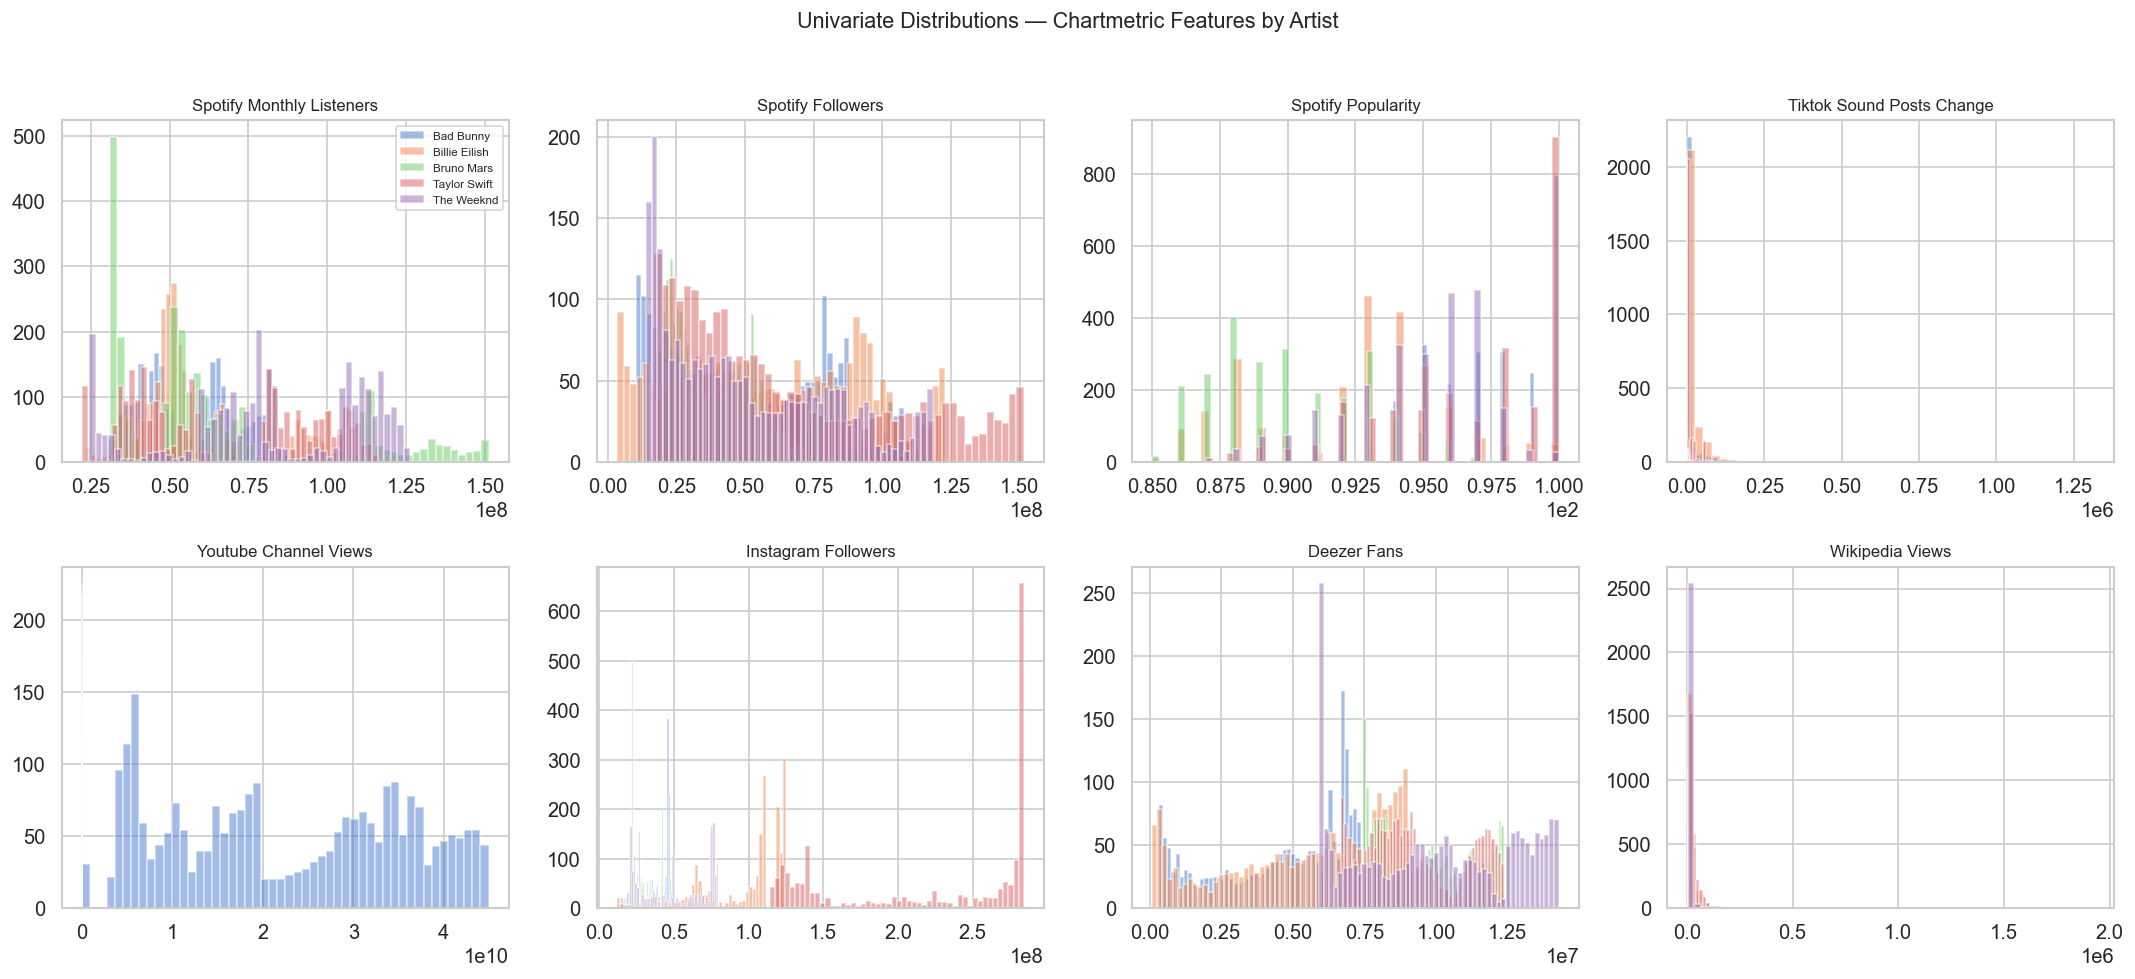

In [ ]:
metric_cols = [
    "spotify_monthly_listeners", "spotify_followers", "spotify_popularity",
    "tiktok_sound_posts_change", "youtube_channel_views",
    "instagram_followers", "deezer_fans", "wikipedia_views",
]
available = [c for c in metric_cols if c in cm.columns and cm[c].notna().sum() > 100]

n = len(available)
fig, axes = plt.subplots(2, (n + 1) // 2, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(available):
    ax = axes[i]
    for artist in sorted(cm["artist_name"].unique()):
        vals = cm.loc[cm["artist_name"] == artist, col].dropna()
        if len(vals) > 10:
            ax.hist(vals, bins=50, alpha=0.5, label=artist)
    ax.set_title(col.replace("_", " ").title(), fontsize=10)
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

axes[0].legend(fontsize=7, loc="upper right")
fig.suptitle("Univariate Distributions — Chartmetric Features by Artist", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# Kalshi price distribution
if not joined.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    for artist in sorted(joined["artist_name"].unique()):
        vals = joined.loc[joined["artist_name"] == artist, "kalshi_close"].dropna()
        axes[0].hist(vals, bins=30, alpha=0.5, label=artist)
    axes[0].set_title("Kalshi Close Price Distribution by Artist")
    axes[0].set_xlabel("Close Price")
    axes[0].legend(fontsize=8)

    joined["kalshi_close"].hist(bins=50, ax=axes[1], color="steelblue", edgecolor="white")
    axes[1].set_title("Kalshi Close Price — All Artists Combined")
    axes[1].set_xlabel("Close Price")
    plt.tight_layout()
    plt.show()

## 5. Time Series Trends

Listener counts, social metrics, and Kalshi prices over time per artist.

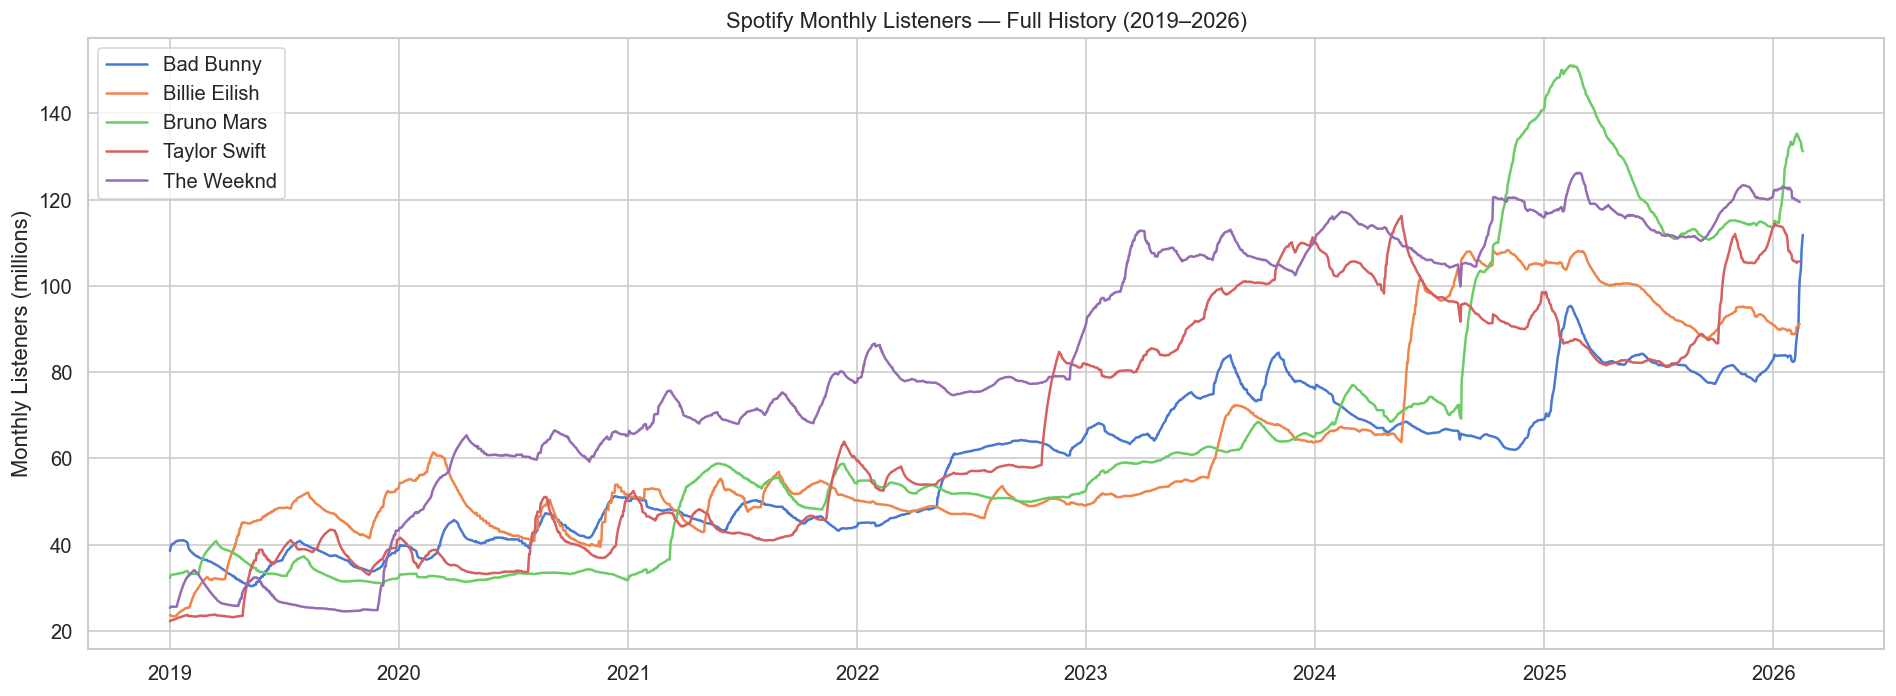

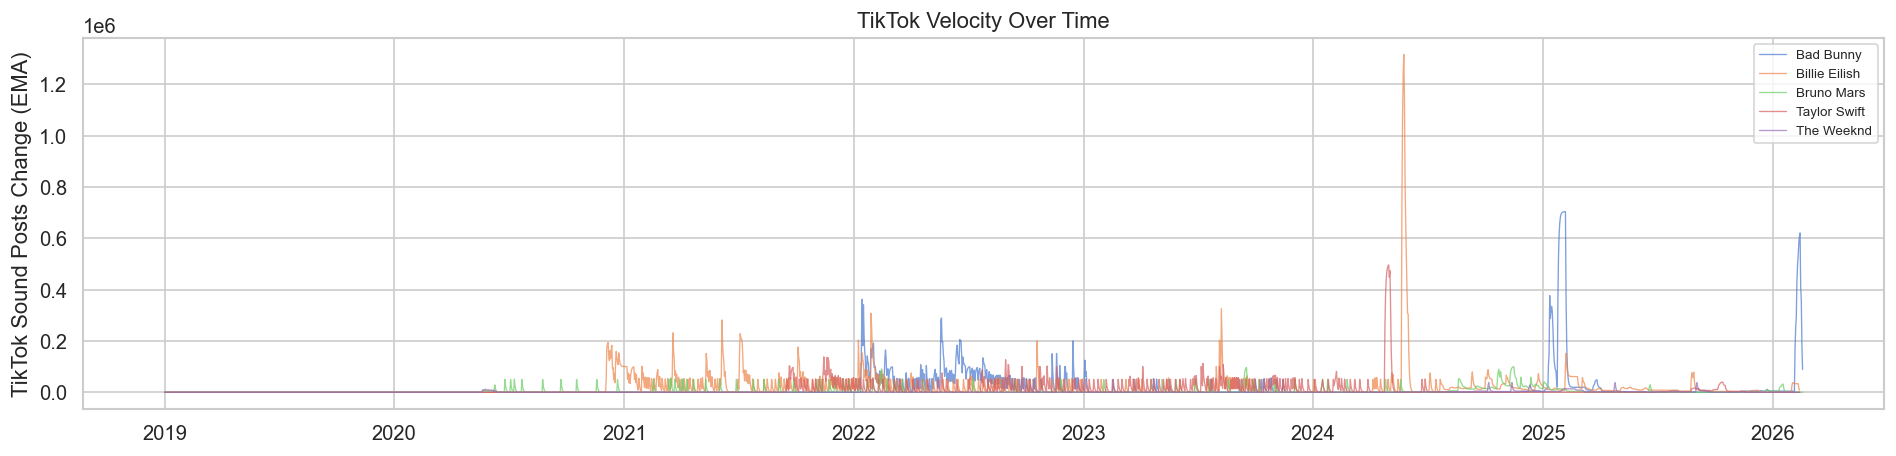

In [ ]:
# Spotify monthly listeners over time — the primary model input
fig, ax = plt.subplots(figsize=(16, 6))
for artist in sorted(cm["artist_name"].unique()):
    sub = cm[cm["artist_name"] == artist].set_index("Date")["spotify_monthly_listeners"].dropna()
    ax.plot(sub.index, sub.values / 1e6, label=artist, linewidth=1.5)
ax.set_ylabel("Monthly Listeners (millions)")
ax.set_title("Spotify Monthly Listeners — Full History (2019–2026)")
ax.legend(loc="upper left")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()

# TikTok velocity
fig, ax = plt.subplots(figsize=(16, 4))
for artist in sorted(cm["artist_name"].unique()):
    sub = cm[cm["artist_name"] == artist].set_index("Date")
    if "tiktok_sound_posts_change" in sub.columns:
        vals = sub["tiktok_sound_posts_change"].dropna()
        if len(vals) > 10:
            ax.plot(vals.index, vals.values, label=artist, alpha=0.7, linewidth=0.8)
ax.set_ylabel("TikTok Sound Posts Change (EMA)")
ax.set_title("TikTok Velocity Over Time")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# Kalshi prices over time — by artist, coloured by month
if not joined.empty:
    artists = sorted(joined["artist_name"].unique())
    fig, axes = plt.subplots(len(artists), 1, figsize=(16, 3.5 * len(artists)), sharex=True)
    if len(artists) == 1:
        axes = [axes]

    cmap = plt.cm.tab10
    months = sorted(joined["market_month"].unique())
    month_colors = {m: cmap(i) for i, m in enumerate(months)}

    for ax, artist in zip(axes, artists):
        sub = joined[joined["artist_name"] == artist]
        for ym in sorted(sub["market_month"].unique()):
            m_sub = sub[sub["market_month"] == ym].sort_values("Date")
            ax.plot(m_sub["Date"], m_sub["kalshi_close"], "o-",
                    color=month_colors[ym], markersize=3, linewidth=1.2, label=ym)
        ax.set_ylabel("Price")
        ax.set_title(f"{artist} — Kalshi Close Price by Month", fontsize=11)
        ax.legend(fontsize=7, ncol=4, loc="upper left")
        ax.set_ylim(-0.02, 1.02)

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

## 6. Cross-Platform Correlation Heatmap

How correlated are the various Chartmetric features *within* each artist? High correlation means redundant features; low correlation means independent information.

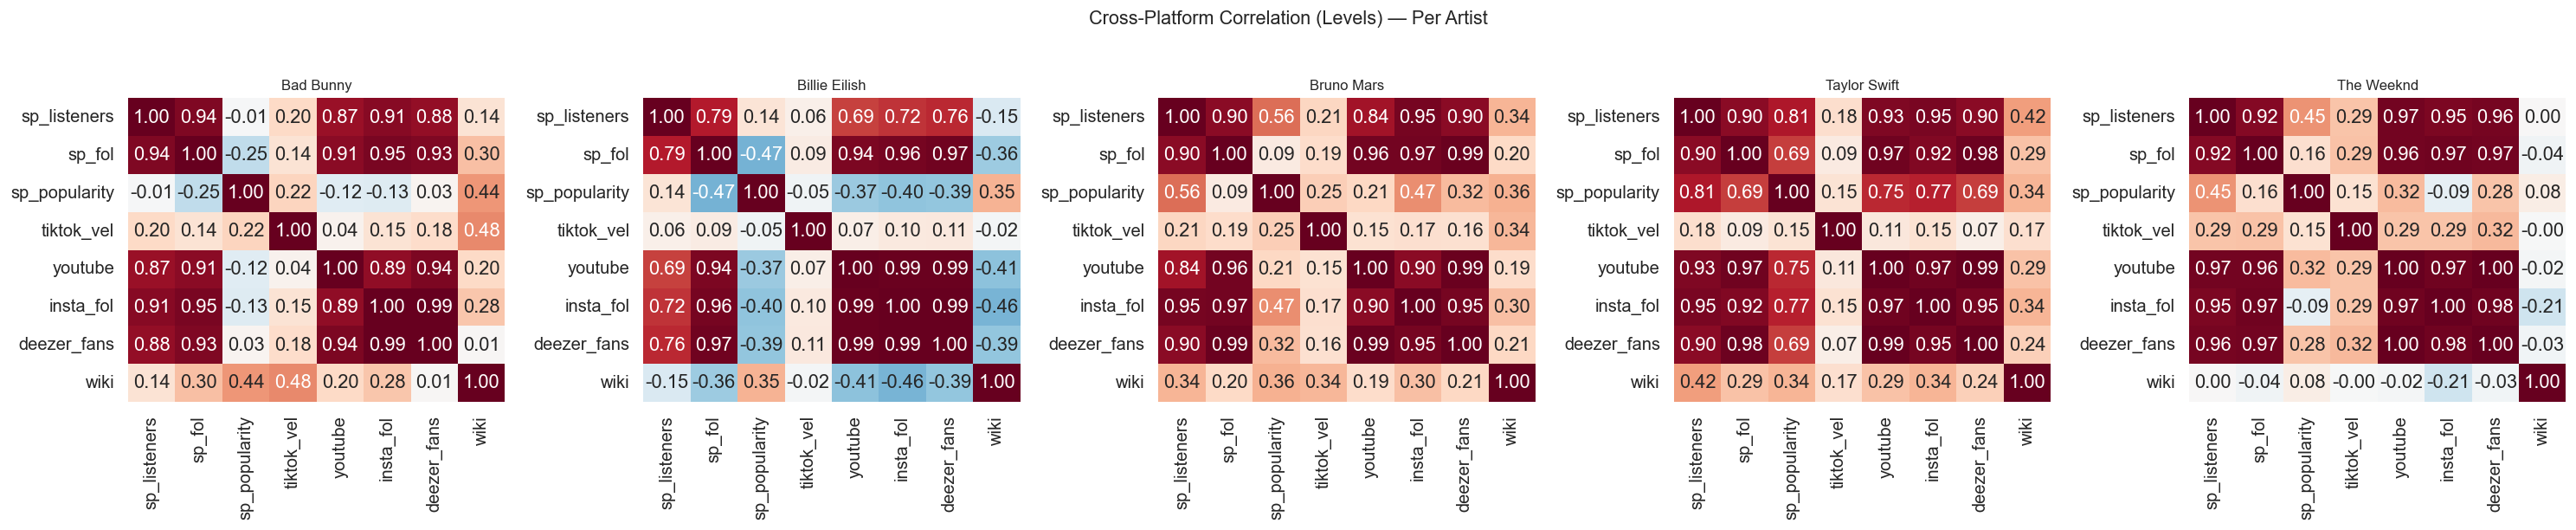

In [ ]:
# Per-artist correlation heatmaps (levels)
corr_cols = [c for c in metric_cols if c in cm.columns and cm[c].notna().sum() > 500]
artists = sorted(cm["artist_name"].unique())

fig, axes = plt.subplots(1, len(artists), figsize=(5 * len(artists), 5))
if len(artists) == 1:
    axes = [axes]

for ax, artist in zip(axes, artists):
    sub = cm[cm["artist_name"] == artist][corr_cols].dropna(how="all")
    corr = sub.corr()
    short_labels = [c.replace("spotify_", "sp_").replace("_followers", "_fol")
                     .replace("monthly_listeners", "listeners")
                     .replace("_channel_views", "")
                     .replace("tiktok_sound_posts_change", "tiktok_vel")
                     .replace("wikipedia_views", "wiki")
                     .replace("instagram", "insta")
                     .replace("soundcloud", "sc") for c in corr.columns]
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
                xticklabels=short_labels, yticklabels=short_labels,
                ax=ax, vmin=-1, vmax=1, cbar=False)
    ax.set_title(artist, fontsize=10)

fig.suptitle("Cross-Platform Correlation (Levels) — Per Artist", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

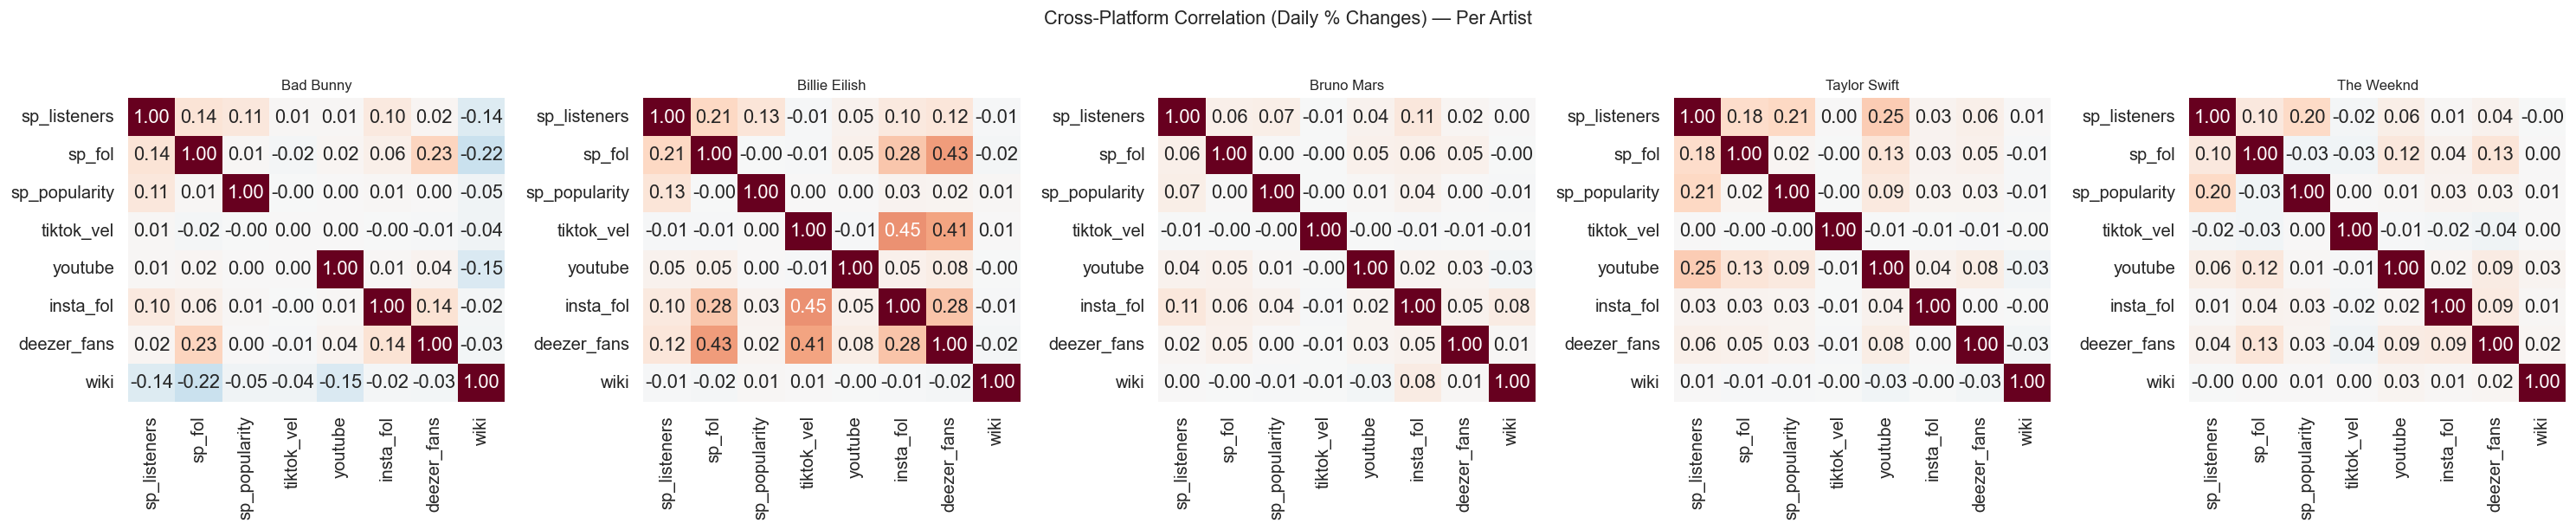

In [ ]:
# Same analysis but on daily CHANGES (diff) — more informative for trading
fig, axes = plt.subplots(1, len(artists), figsize=(5 * len(artists), 5))
if len(artists) == 1:
    axes = [axes]

for ax, artist in zip(axes, artists):
    sub = cm[cm["artist_name"] == artist].set_index("Date")[corr_cols].sort_index()
    # Percent changes for levels, raw diff for bounded metrics
    changes = sub.pct_change().replace([np.inf, -np.inf], np.nan).dropna(how="all")
    corr = changes.corr()
    short_labels = [c.replace("spotify_", "sp_").replace("_followers", "_fol")
                     .replace("monthly_listeners", "listeners")
                     .replace("_channel_views", "")
                     .replace("tiktok_sound_posts_change", "tiktok_vel")
                     .replace("wikipedia_views", "wiki")
                     .replace("instagram", "insta")
                     .replace("soundcloud", "sc") for c in corr.columns]
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
                xticklabels=short_labels, yticklabels=short_labels,
                ax=ax, vmin=-1, vmax=1, cbar=False)
    ax.set_title(artist, fontsize=10)

fig.suptitle("Cross-Platform Correlation (Daily % Changes) — Per Artist", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 7. Feature vs Kalshi Price Correlation

The key question: which Chartmetric features correlate with Kalshi market prices? We look at both level correlations and change-on-change correlations.

In [ ]:
if not joined.empty:
    # Compute derived features in the joined dataset
    joined = joined.sort_values(["artist_name", "market_month", "Date"])

    # Listener gap: this artist vs the max of other artists on same date
    def compute_gap(group):
        """For each row, find the max listeners among other artists on same date."""
        dates = group.set_index("Date")["spotify_monthly_listeners"]
        return dates

    # Per-artist daily returns
    joined["listener_pct_change"] = joined.groupby(
        ["artist_name", "market_month"]
    )["spotify_monthly_listeners"].pct_change()

    joined["kalshi_price_change"] = joined.groupby(
        ["artist_name", "market_month"]
    )["kalshi_close"].diff()

    # 7-day rolling listener change
    joined["listener_7d_pct"] = joined.groupby(
        ["artist_name", "market_month"]
    )["spotify_monthly_listeners"].transform(
        lambda x: x.pct_change(periods=7)
    )

    # Correlation: each feature vs Kalshi close (per artist)
    corr_features = [c for c in metric_cols if c in joined.columns]
    corr_features += ["listener_pct_change", "listener_7d_pct"]

    print("=" * 80)
    print("LEVEL CORRELATIONS: Feature vs Kalshi Close Price (per artist × month)")
    print("=" * 80)

    level_corrs = []
    for artist in sorted(joined["artist_name"].unique()):
        for ym in sorted(joined[joined["artist_name"] == artist]["market_month"].unique()):
            sub = joined[(joined["artist_name"] == artist) & (joined["market_month"] == ym)]
            if len(sub) < 5:
                continue
            for feat in corr_features:
                pair = sub[["kalshi_close", feat]].dropna()
                if len(pair) >= 5:
                    r, p = sp_stats.pearsonr(pair["kalshi_close"], pair[feat])
                    level_corrs.append({
                        "artist": artist, "month": ym, "feature": feat,
                        "pearson_r": round(r, 4), "p_value": round(p, 4),
                        "n": len(pair),
                    })

    corr_df = pd.DataFrame(level_corrs)
    if not corr_df.empty:
        # Average correlation per feature across all artist-months
        avg_corr = corr_df.groupby("feature")["pearson_r"].agg(["mean", "std", "count"])
        avg_corr = avg_corr.sort_values("mean", ascending=False)
        display(avg_corr.round(3))

        # Heatmap: feature × artist (average across months)
        pivot = corr_df.groupby(["feature", "artist"])["pearson_r"].mean().unstack()
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdBu_r", center=0, ax=ax)
        ax.set_title("Avg Pearson r: Feature vs Kalshi Close (by Artist, across Months)")
        plt.tight_layout()
        plt.show()

In [ ]:
# Change-on-change correlations (more relevant for prediction)
if not joined.empty and "kalshi_price_change" in joined.columns:
    print("=" * 80)
    print("CHANGE-ON-CHANGE CORRELATIONS: Δ Feature vs Δ Kalshi Price")
    print("=" * 80)

    chg_corrs = []
    change_features = ["listener_pct_change", "tiktok_sound_posts_change"]
    change_features = [c for c in change_features if c in joined.columns]

    for artist in sorted(joined["artist_name"].unique()):
        for ym in sorted(joined[joined["artist_name"] == artist]["market_month"].unique()):
            sub = joined[(joined["artist_name"] == artist) & (joined["market_month"] == ym)].copy()
            if len(sub) < 5:
                continue
            for feat in change_features:
                pair = sub[["kalshi_price_change", feat]].dropna()
                if len(pair) >= 5:
                    r, p = sp_stats.pearsonr(pair["kalshi_price_change"], pair[feat])
                    chg_corrs.append({
                        "artist": artist, "month": ym, "feature": feat,
                        "pearson_r": round(r, 4), "p_value": round(p, 4),
                        "n": len(pair),
                    })

    chg_df = pd.DataFrame(chg_corrs)
    if not chg_df.empty:
        avg_chg = chg_df.groupby("feature")["pearson_r"].agg(["mean", "std", "count"])
        avg_chg = avg_chg.sort_values("mean", ascending=False)
        print("\nAvg change-on-change correlation:")
        display(avg_chg.round(3))

        # Scatter: daily listener change vs daily Kalshi price change
        fig, axes = plt.subplots(1, len(change_features), figsize=(7 * len(change_features), 5))
        if len(change_features) == 1:
            axes = [axes]

        for ax, feat in zip(axes, change_features):
            for artist in sorted(joined["artist_name"].unique()):
                sub = joined[joined["artist_name"] == artist]
                ax.scatter(sub[feat], sub["kalshi_price_change"],
                          alpha=0.3, s=15, label=artist)
            ax.set_xlabel(feat.replace("_", " ").title())
            ax.set_ylabel("Kalshi Daily Price Change")
            ax.set_title(f"Δ {feat.split('_')[0].title()} vs Δ Kalshi Price")
            ax.legend(fontsize=7)
            ax.axhline(0, color="gray", linestyle="--", linewidth=0.5)
            ax.axvline(0, color="gray", linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

## 8. Volatility & Momentum Analysis

Examine realised volatility of listeners vs Kalshi price volatility. Do volatile listener counts lead to volatile market prices?

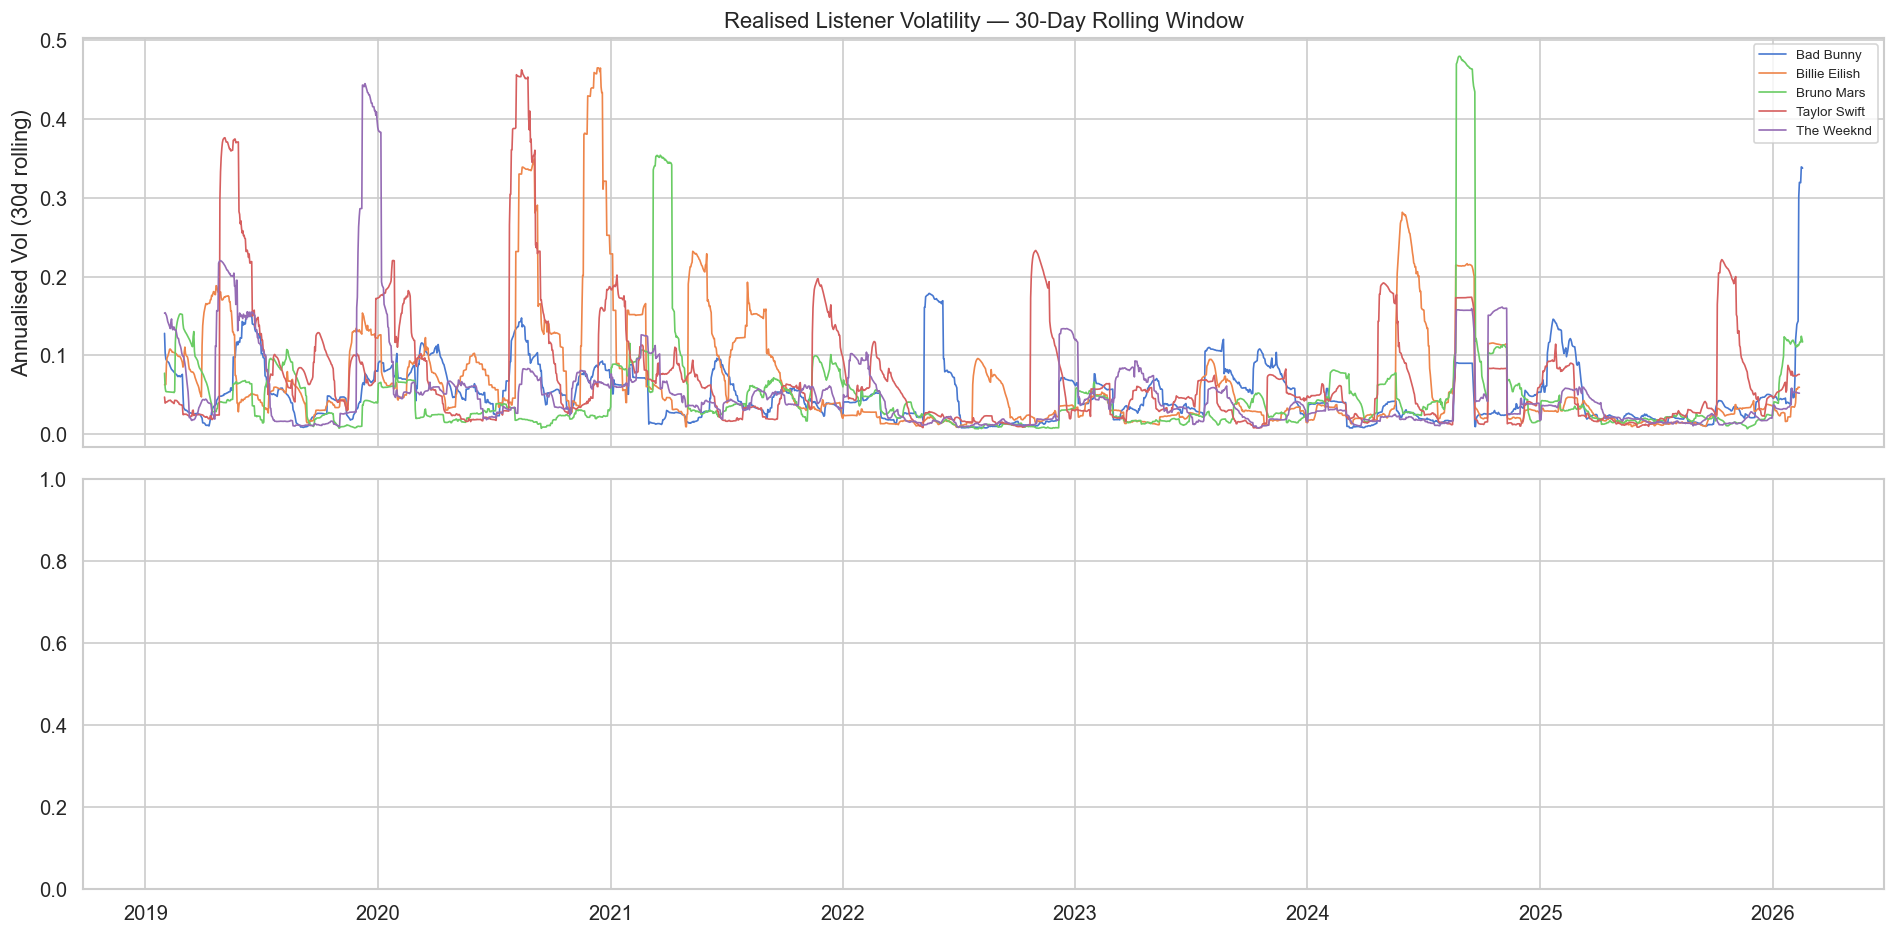


COMPETITIVE DYNAMICS: Listener Gaps Between Top Artists


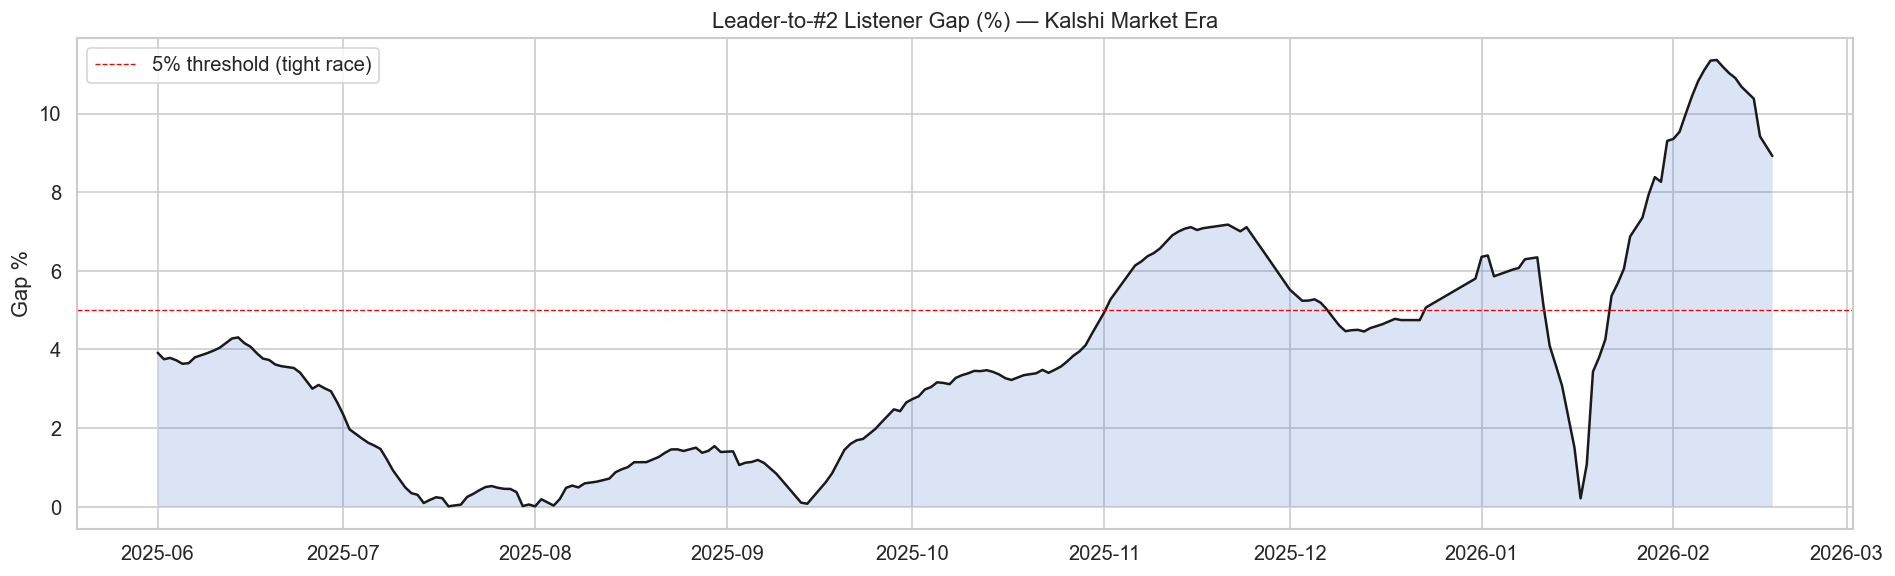


Leader by date (last 30 days):


,Leader
Date,
2026-01-19,Bruno Mars
2026-01-20,Bruno Mars
2026-01-21,Bruno Mars
2026-01-22,Bruno Mars
2026-01-23,Bruno Mars
2026-01-24,Bruno Mars
2026-01-25,Bruno Mars
2026-01-26,Bruno Mars
2026-01-27,Bruno Mars


In [ ]:
# Per-artist realised volatility over rolling windows
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

for artist in sorted(cm["artist_name"].unique()):
    sub = cm[cm["artist_name"] == artist].set_index("Date")["spotify_monthly_listeners"].dropna()
    daily_ret = sub.pct_change().dropna()
    vol_30d = daily_ret.rolling(30).std() * np.sqrt(365)
    axes[0].plot(vol_30d.index, vol_30d.values, label=artist, linewidth=1)

axes[0].set_ylabel("Annualised Vol (30d rolling)")
axes[0].set_title("Realised Listener Volatility — 30-Day Rolling Window")
axes[0].legend(fontsize=8)

# Kalshi price vol (if available)
if not joined.empty:
    for artist in sorted(joined["artist_name"].unique()):
        sub = joined[joined["artist_name"] == artist].set_index("Date")["kalshi_close"].sort_index()
        daily_chg = sub.diff().dropna()
        vol_7d = daily_chg.rolling(7, min_periods=3).std()
        axes[1].plot(vol_7d.index, vol_7d.values, "o-", markersize=2, linewidth=1, label=artist)
    axes[1].set_ylabel("Price Vol (7d rolling std)")
    axes[1].set_title("Kalshi Price Volatility — 7-Day Rolling Std of Daily Change")
    axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Listener gap analysis (competitive dynamics)
print("\n" + "=" * 80)
print("COMPETITIVE DYNAMICS: Listener Gaps Between Top Artists")
print("=" * 80)

# Build a wide format: Date × artist listeners (using only the Kalshi-era data)
kalshi_era = cm[cm["Date"] >= "2025-06-01"]
wide = kalshi_era.pivot_table(index="Date", columns="artist_name",
                               values="spotify_monthly_listeners")
wide = wide.dropna(how="all").sort_index().ffill()

if not wide.empty:
    fig, ax = plt.subplots(figsize=(16, 5))
    leader = wide.idxmax(axis=1)
    gap_pct = (wide.max(axis=1) - wide.apply(lambda row: row.nlargest(2).iloc[-1], axis=1)) / wide.max(axis=1) * 100

    ax.plot(gap_pct.index, gap_pct.values, "k-", linewidth=1.5)
    ax.fill_between(gap_pct.index, 0, gap_pct.values, alpha=0.2)
    ax.set_ylabel("Gap %")
    ax.set_title("Leader-to-#2 Listener Gap (%) — Kalshi Market Era")
    ax.axhline(5, color="red", linestyle="--", linewidth=0.8, label="5% threshold (tight race)")
    ax.legend()
    plt.tight_layout()
    plt.show()

    print("\nLeader by date (last 30 days):")
    display(leader.tail(30).to_frame("Leader"))

## 9. Lead-Lag: Do Chartmetric Features Move Before Kalshi Prices?

Cross-correlation at various lags: if a feature at lag -k (k days earlier) correlates with today's Kalshi price change, that feature *leads* the market.

In [ ]:
if not joined.empty:
    lag_range = range(-5, 6)  # -5 = feature 5 days BEFORE price, +5 = feature 5 days AFTER
    lead_features = ["listener_pct_change", "tiktok_sound_posts_change"]
    lead_features = [f for f in lead_features if f in joined.columns]

    fig, axes = plt.subplots(1, len(lead_features), figsize=(8 * len(lead_features), 5))
    if len(lead_features) == 1:
        axes = [axes]

    for ax, feat in zip(axes, lead_features):
        for artist in sorted(joined["artist_name"].unique()):
            lag_corrs = []
            for lag in lag_range:
                sub = joined[joined["artist_name"] == artist].copy()
                sub = sub.sort_values("Date")
                shifted = sub[feat].shift(-lag)  # negative lag = feature leads
                pair = pd.DataFrame({"price_chg": sub["kalshi_price_change"], "feat": shifted}).dropna()
                if len(pair) >= 5:
                    r, _ = sp_stats.pearsonr(pair["price_chg"], pair["feat"])
                    lag_corrs.append(r)
                else:
                    lag_corrs.append(np.nan)
            ax.plot(list(lag_range), lag_corrs, "o-", markersize=4, label=artist)

        ax.axhline(0, color="gray", linestyle="--", linewidth=0.5)
        ax.axvline(0, color="gray", linestyle=":", linewidth=0.5)
        ax.set_xlabel("Lag (negative = feature LEADS price)")
        ax.set_ylabel("Pearson r")
        ax.set_title(f"Cross-Correlation: {feat} vs Δ Kalshi Price")
        ax.legend(fontsize=7)

    plt.tight_layout()
    plt.show()

    # Granger-style: does lagged feature predict next-day price change?
    print("\n" + "=" * 80)
    print("PREDICTIVE VALUE: Does yesterday's feature predict today's price change?")
    print("=" * 80)

    for feat in lead_features:
        print(f"\n--- {feat} (lag=1) ---")
        for artist in sorted(joined["artist_name"].unique()):
            sub = joined[joined["artist_name"] == artist].sort_values("Date").copy()
            sub["feat_lag1"] = sub[feat].shift(1)
            pair = sub[["kalshi_price_change", "feat_lag1"]].dropna()
            if len(pair) >= 10:
                r, p = sp_stats.pearsonr(pair["kalshi_price_change"], pair["feat_lag1"])
                sig = "***" if p < 0.01 else "**" if p < 0.05 else "*" if p < 0.10 else ""
                print(f"  {artist:<20s}  r={r:+.4f}  p={p:.4f} {sig}  (n={len(pair)})")

## 10. Listener Rank vs Market Outcome

Does the listener rank at various points during the month predict the actual winner? How stable is the ranking?

In [ ]:
# Build month-by-month listener ranking table
resolved = {k: v for k, v in ACTUAL_WINNERS.items() if v is not None}

if not wide.empty and resolved:
    print("=" * 80)
    print("LISTENER RANK vs ACTUAL WINNER")
    print("=" * 80)

    rank_accuracy = []

    for ym, winner in resolved.items():
        ym_ts = pd.Timestamp(f"{ym}-01")
        month_end = ym_ts + pd.offsets.MonthEnd(0)
        month_data = wide.loc[ym_ts:month_end].dropna(how="all")
        if month_data.empty:
            continue

        # Rank at start, mid, and end of month
        for label, idx in [("start", 0), ("mid", len(month_data) // 2), ("end", -1)]:
            row = month_data.iloc[idx]
            ranked = row.sort_values(ascending=False)
            leader = ranked.index[0]
            is_correct = leader == winner
            rank_accuracy.append({
                "month": ym, "when": label, "leader": leader,
                "actual_winner": winner, "correct": is_correct,
                "leader_listeners": int(ranked.iloc[0]),
                "gap_to_2nd_pct": round(
                    (ranked.iloc[0] - ranked.iloc[1]) / ranked.iloc[0] * 100, 2
                ) if len(ranked) > 1 else None,
            })

    rank_df = pd.DataFrame(rank_accuracy)
    display(rank_df)

    # Accuracy summary
    for when in ["start", "mid", "end"]:
        sub = rank_df[rank_df["when"] == when]
        acc = sub["correct"].mean()
        print(f"  Rank-1 predicts winner at month {when}: {acc:.0%} ({sub['correct'].sum()}/{len(sub)})")

    # Average gap when leader wins vs doesn't
    if len(rank_df) > 0:
        print(f"\n  Avg gap when leader wins:  {rank_df[rank_df['correct']]['gap_to_2nd_pct'].mean():.1f}%")
        print(f"  Avg gap when leader loses: {rank_df[~rank_df['correct']]['gap_to_2nd_pct'].mean():.1f}%")

## 11. Summary Statistics & Missing Data Report

Final summary: data coverage, missingness, and key takeaways for the team.

DATA COVERAGE REPORT


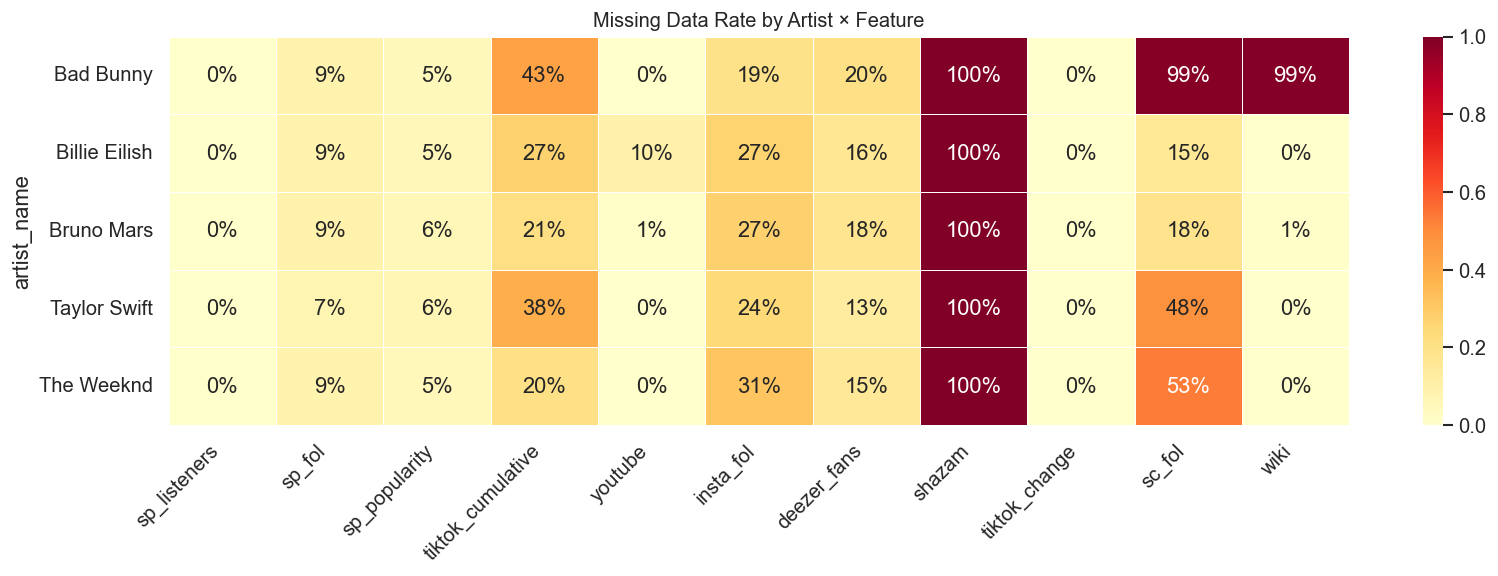


Per-artist summary:

  Bad Bunny:
    Date range:  2019-01-01 → 2026-02-17
    Total rows:  2,594
    Listeners:   111,817,920 (latest)
    Followers:   109,861,020

  Billie Eilish:
    Date range:  2019-01-01 → 2026-02-12
    Total rows:  2,590
    Listeners:   91,125,690 (latest)
    Followers:   122,937,740

  Bruno Mars:
    Date range:  2019-01-01 → 2026-02-17
    Total rows:  2,595
    Listeners:   131,171,650 (latest)
    Followers:   78,066,270

  Taylor Swift:
    Date range:  2019-01-01 → 2026-02-12
    Total rows:  2,589
    Listeners:   105,641,010 (latest)
    Followers:   151,446,620

  The Weeknd:
    Date range:  2019-01-01 → 2026-02-12
    Total rows:  2,589
    Listeners:   119,471,210 (latest)
    Followers:   118,250,690


In [ ]:
# Missing data heatmap
print("=" * 80)
print("DATA COVERAGE REPORT")
print("=" * 80)

fig, ax = plt.subplots(figsize=(14, 5))
missing = cm.groupby("artist_name")[feature_cols].apply(lambda x: x.isna().mean())
sns.heatmap(missing, annot=True, fmt=".0%", cmap="YlOrRd", ax=ax,
            vmin=0, vmax=1, linewidths=0.5)
ax.set_title("Missing Data Rate by Artist × Feature", fontsize=12)
short_labels = [c.replace("spotify_", "sp_").replace("_followers", "_fol")
                 .replace("monthly_listeners", "listeners")
                 .replace("_channel_views", "")
                 .replace("tiktok_sound_posts_", "tiktok_")
                 .replace("wikipedia_views", "wiki")
                 .replace("instagram", "insta")
                 .replace("soundcloud", "sc")
                 .replace("shazam_count", "shazam") for c in feature_cols]
ax.set_xticklabels(short_labels, rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Summary per artist
print("\nPer-artist summary:")
for artist in sorted(cm["artist_name"].unique()):
    sub = cm[cm["artist_name"] == artist]
    print(f"\n  {artist}:")
    print(f"    Date range:  {sub['Date'].min().date()} → {sub['Date'].max().date()}")
    print(f"    Total rows:  {len(sub):,}")
    print(f"    Listeners:   {sub['spotify_monthly_listeners'].iloc[-1]:,.0f} (latest)")
    if "spotify_followers" in sub.columns:
        print(f"    Followers:   {sub['spotify_followers'].dropna().iloc[-1]:,.0f}" if sub['spotify_followers'].notna().any() else "    Followers:   N/A")

# Joined dataset summary
if not joined.empty:
    print(f"\n{'=' * 80}")
    print(f"JOINED DATASET (Chartmetric + Kalshi)")
    print(f"{'=' * 80}")
    print(f"  Total rows:     {len(joined):,}")
    print(f"  Date range:     {joined['Date'].min().date()} → {joined['Date'].max().date()}")
    print(f"  Artists:        {sorted(joined['artist_name'].unique())}")
    print(f"  Market months:  {sorted(joined['market_month'].unique())}")
    print(f"  Avg trades/day: {joined['kalshi_volume'].mean():.1f}")
    print(f"\n  Files saved in: {output_dir}")
    print(f"    - full_joined_dataset_{today}.csv")
    print(f"    - chartmetric_panel_{today}.csv")
    print(f"    - kalshi_prices_{today}.csv")